> Context :

We started working on the mobile apps vertical in July 2020. After preliminary expert calls with mobile gaming editors, it appeared that 2 important labels were needed in our datasets to make any kind of useful analysis: the app title (eg “Candy Crush Saga”) and the editor name (eg “King”)

Using receipt data from the App Store (iOs) and the Play Store (Android), F* can collect one very valuable information for mobile apps editors: in-app purchases (IAP) data, which are any type of transaction where a user pays from inside an application

Unfortunately, App Store receipts display very little information: we can only collect the name of the IAP (eg “gros sac de gemmes”), the url of the logo of the application and the price of the IAP

Using external data, we managed to collect a database of logo URLs and corresponding app name and editor name
     
> Questions

Using the table extract and the external source extract, your goal is to enable insights on app monetization strategies:

    1. Enrich the table extract to add an app title and editor name for each record by matching the images behind each URL with the ones in the external source extract
    2. Analyze the enriched extract and make a short presentation (3 slides max) aimed at app editors with your conclusions on the impact of the Covid confinement in France  
     

# IMPORT LIBRARIES

In [66]:
import pandas as pd
pd.options.display.max_colwidth = 150

import requests
import calendar

from PIL import Image
from io import BytesIO
from mpl_toolkits.axes_grid1 import ImageGrid
import imagehash

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# ENRICH THE TABLE EXTRACT

## IMPORT DATASET

In [2]:
df = pd.read_csv("technical_test_external_source_extract.csv")
df_2 = pd.read_csv("technical_test_table_extract.csv")

In [3]:
print(df.shape)
print(df_2.shape)

(86, 3)
(31572, 5)


In [4]:
df.head(10)

,title,editor,icon
0,Candy Crush Saga,King,https://is4-ssl.mzstatic.com/image/thumb/Purple114/v4/89/7a/5a/897a5a04-328a-1483-fea3-db9fa22cae78/source/100x100bb.jpg
1,Netflix,"Netflix, Inc.",https://is1-ssl.mzstatic.com/image/thumb/Purple123/v4/13/f4/04/13f4044c-5831-b8c1-4a23-4573f2c32cc0/source/100x100bb.jpg
2,myCANAL,GROUPE CANAL+,https://is5-ssl.mzstatic.com/image/thumb/Purple123/v4/a1/91/ba/a191ba26-09be-a6f5-552e-fab0c178d0c0/source/100x100bb.jpg
3,Homescapes,Playrix,https://is5-ssl.mzstatic.com/image/thumb/Purple113/v4/56/d3/b1/56d3b188-3326-7847-7f7f-053a53fb915c/source/100x100bb.jpg
4,Tinder,Tinder Inc.,https://is4-ssl.mzstatic.com/image/thumb/Purple113/v4/4d/13/40/4d1340fa-73a5-bbdf-dd5e-301b8472a89a/source/100x100bb.jpg
5,Tinder,Tinder Inc.,https://is1-ssl.mzstatic.com/image/thumb/Purple124/v4/93/cf/51/93cf510e-f06a-8031-4598-8d6b14feb747/source/100x100bb.jpg
6,myCANAL,GROUPE CANAL+,https://is2-ssl.mzstatic.com/image/thumb/Purple113/v4/8d/0d/8a/8d0d8a9d-7a24-807a-0a95-bc82d0b07b24/source/100x100bb.jpg
7,Homescapes,Playrix,https://is4-ssl.mzstatic.com/image/thumb/Purple123/v4/23/60/64/23606449-9a5c-9cf6-1aad-6d5aff482655/source/100x100bb.jpg
8,Candy Crush Saga,King,https://is3-ssl.mzstatic.com/image/thumb/Purple114/v4/a9/73/8d/a9738de1-a8de-f8e2-58b2-187e4960b0a8/source/100x100bb.jpg
9,Brawl Stars,Supercell,https://is2-ssl.mzstatic.com/image/thumb/Purple123/v4/6f/8d/87/6f8d876e-b445-ae85-0782-5bcedefeb4cd/source/100x100bb.jpg


In [5]:
df_2.head(10)

,id_order,year_month,order_total_paid,product_name,product_url_img
0,97337926,2020-06,6.99,1 boost,https://is5-ssl.mzstatic.com/image/thumb/Purple123/v4/27/11/28/27112846-9d92-8fe4-d8a6-e427cb6a040a/AppIcon-1x_U007emarketing-0-7-0-0-85-220.png/1...
1,97518205,2020-06,27.99,5 boosts,https://is5-ssl.mzstatic.com/image/thumb/Purple123/v4/27/11/28/27112846-9d92-8fe4-d8a6-e427cb6a040a/AppIcon-1x_U007emarketing-0-7-0-0-85-220.png/1...
2,97424538,2020-06,16.49,tinder gold,https://is5-ssl.mzstatic.com/image/thumb/Purple123/v4/27/11/28/27112846-9d92-8fe4-d8a6-e427cb6a040a/AppIcon-1x_U007emarketing-0-7-0-0-85-220.png/1...
3,99165099,2020-06,7.49,tinder gold,https://is5-ssl.mzstatic.com/image/thumb/Purple123/v4/27/11/28/27112846-9d92-8fe4-d8a6-e427cb6a040a/AppIcon-1x_U007emarketing-0-7-0-0-85-220.png/1...
4,110834238,2020-06,32.99,tinder gold,https://is5-ssl.mzstatic.com/image/thumb/Purple123/v4/27/11/28/27112846-9d92-8fe4-d8a6-e427cb6a040a/AppIcon-1x_U007emarketing-0-7-0-0-85-220.png/1...
5,98880800,2020-06,8.99,5 super likes,https://is5-ssl.mzstatic.com/image/thumb/Purple123/v4/27/11/28/27112846-9d92-8fe4-d8a6-e427cb6a040a/AppIcon-1x_U007emarketing-0-7-0-0-85-220.png/1...
6,99540437,2020-06,16.49,tinder gold (renouvellement automatique),https://is5-ssl.mzstatic.com/image/thumb/Purple123/v4/27/11/28/27112846-9d92-8fe4-d8a6-e427cb6a040a/AppIcon-1x_U007emarketing-0-7-0-0-85-220.png/1...
7,99681154,2020-06,16.49,tinder gold (renouvellement automatique),https://is5-ssl.mzstatic.com/image/thumb/Purple123/v4/27/11/28/27112846-9d92-8fe4-d8a6-e427cb6a040a/AppIcon-1x_U007emarketing-0-7-0-0-85-220.png/1...
8,97640801,2020-06,32.99,tinder gold (renouvellement automatique),https://is5-ssl.mzstatic.com/image/thumb/Purple123/v4/27/11/28/27112846-9d92-8fe4-d8a6-e427cb6a040a/AppIcon-1x_U007emarketing-0-7-0-0-85-220.png/1...
9,100195949,2020-06,16.49,tinder gold (renouvellement automatique),https://is5-ssl.mzstatic.com/image/thumb/Purple123/v4/27/11/28/27112846-9d92-8fe4-d8a6-e427cb6a040a/AppIcon-1x_U007emarketing-0-7-0-0-85-220.png/1...


## Check images details behind the url

> This process below was done for all applications

In [6]:
df_Candy = df[df.title == 'Candy Crush Saga'].reset_index()

In [7]:
list_of_image = [Image.open(BytesIO(requests.get(df_Candy.icon[i]).content)) for i in range(len(df_Candy))]

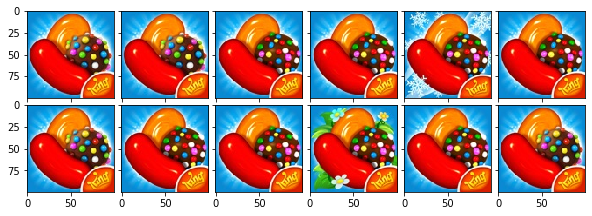

In [8]:
fig = plt.figure(1,(10,10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2,6),
                 axes_pad=0.1,
                 )
for i in range(len(list_of_image)):
    img = list_of_image[i]
    grid[i].imshow(img, cmap='gray',interpolation='none')

## Creation of a link list for each application (some have multiple images like above)

In [ ]:
df_one = df.sort_values('title').groupby(['title']).first()

In [ ]:
liste_dif_candy = ['https://is1-ssl.mzstatic.com/image/thumb/Purple113/v4/ea/ab/60/eaab60cf-d326-9f45-d2c0-5e7147c6ad05/source/100x100bb.jpg','https://is5-ssl.mzstatic.com/image/thumb/Purple113/v4/a1/a9/cb/a1a9cb3b-1ce0-4275-3907-e95eb35c1ae6/source/100x100bb.jpg']
liste_dif_clash = ['https://is3-ssl.mzstatic.com/image/thumb/Purple123/v4/f9/25/24/f92524fc-c53b-e4f7-3131-daa96102291f/source/100x100bb.jpg']
liste_dif_brawl = ['https://is2-ssl.mzstatic.com/image/thumb/Purple114/v4/d7/f3/18/d7f3186f-de15-670d-e971-fe1c795b9471/source/100x100bb.jpg', 'https://is1-ssl.mzstatic.com/image/thumb/Purple123/v4/df/9b/2e/df9b2e38-6e42-e51d-ea74-4593e14f22ef/source/100x100bb.jpg']
liste_dif_homescapes = ['https://is3-ssl.mzstatic.com/image/thumb/Purple114/v4/ec/37/e0/ec37e04c-ad1e-3905-cfa3-b808a92dc30e/source/100x100bb.jpg','https://is3-ssl.mzstatic.com/image/thumb/Purple124/v4/9a/96/08/9a96088b-f629-e122-6a78-d8c37ab1e4c5/source/100x100bb.jpg']

In [ ]:
list_of_links = list(df_one.icon.values)
list_of_links = list_of_links + liste_dif_candy + liste_dif_clash + liste_dif_brawl + liste_dif_homescapes

## Creation of a function to merge the dataset

> That compare each link from the table extract with the filtered list of links. If the hashed image correspond to the other image, the function return the link from the list. That way it is possible to merge the dataframes after.

In [ ]:
def test_image(link):
    cutoff = 10
    r = requests.get(link)
    hash0 = imagehash.average_hash(Image.open(BytesIO(r.content)))
    for link_test in list_of_links: 
        r2 = requests.get(link_test)
        hash1 = imagehash.average_hash(Image.open(BytesIO(r2.content)))
        if hash0 - hash1 < cutoff:
            return link_test
        else:
            continue

In [ ]:
# Apply the function to the product url image columns
df_2['link_to_merge'] = df_2.product_url_img.apply(lambda x: test_image(x))

> Fill the dataframes with a Netflix link (One of the netflix url in the table extract do not match with any url in the first dataset)

In [ ]:
df_2 = df_2.fillna('https://is1-ssl.mzstatic.com/image/thumb/Purple123/v4/13/f4/04/13f4044c-5831-b8c1-4a23-4573f2c32cc0/source/100x100bb.jpg')

> Merge the table extract with the external source extract

In [ ]:
clean_df = df_2.rename(columns={"link_to_merge": "icon"})

In [ ]:
merged_df = pd.merge(df,clean_df, how='right', on='icon')

In [ ]:
merged_df.to_csv('enriched.csv')

# ANALYSE THE TABLE EXTRACT

## Clean dataset

In [2]:
# Create dataframe
df = pd.read_csv('enriched.csv', index_col=0)

In [3]:
df.shape

(31572, 6)

In [4]:
df.head(10)

,title,editor,id_order,year_month,order_total_paid,product_name
0,Netflix,"Netflix, Inc.",97471001,2020-06,7.99,netflix 1 ecran - streaming illimite (renouvellement automatique)
1,Netflix,"Netflix, Inc.",97756247,2020-06,11.99,netflix 2 ecrans - streaming illimite (renouvellement automatique)
2,Netflix,"Netflix, Inc.",97482686,2020-06,11.99,netflix 2 screens - unlimited streaming (renouvellement automatique)
3,Netflix,"Netflix, Inc.",99196090,2020-06,11.99,netflix 2 screens - unlimited streaming (renouvellement automatique)
4,Netflix,"Netflix, Inc.",99511555,2020-06,15.99,netflix 4 screens - unlimited streaming (renouvellement automatique)
5,Netflix,"Netflix, Inc.",98473441,2020-06,15.99,netflix 4 screens - unlimited streaming (renouvellement automatique)
6,Brawl Stars,Supercell,97462690,2020-06,2.29,30 gemmes
7,Brawl Stars,Supercell,99848271,2020-06,10.99,170 gemmes
8,Brawl Stars,Supercell,100344945,2020-06,10.99,170 gemmes
9,Brawl Stars,Supercell,97331736,2020-06,10.99,170 gemmes


In [5]:
df['month'] = pd.DatetimeIndex(df['year_month']).month

In [6]:
df['month_name'] = df['month'].apply(lambda x: calendar.month_abbr[x])

In [7]:
# drop the useless columns
df = df.drop(["id_order","product_name","year_month"],axis = 1)

## Graphics and EDA

### EDA

In [9]:
df.describe()

,order_total_paid,month
count,31572.000000,31572.000000
mean,9.919889,5.568542
std,10.069172,2.389430
min,0.260000,1.000000
25%,5.490000,4.000000
50%,6.990000,6.000000
75%,11.990000,8.000000
max,164.990000,9.000000


In [12]:
# Display total paid distribution for all app
fig = px.box(df, 
             y="order_total_paid",
             color = 'title',
             title= "Order total paid distribution by app title"
             )

fig.update_layout(title_x = 0.5,
                  autosize = True,
                  margin=dict(l=50,r=50,b=50,t=50,pad=4),
                  yaxis_title = 'Total paid',
                  xaxis_title = '',
                  template = 'plotly_dark'
                  )                              
fig.show()

In [13]:
data = round(df.groupby('title').order_total_paid.sum()).rename_axis('title').reset_index(name='Total')

In [14]:
# Barplot : Total orders paid by app title in 2020
fig = px.bar(data, x="title",
                   y="Total",
                   title = 'Total orders paid for the apps',
                   text_auto = True
                   )
fig.update_traces(textposition = 'outside', textfont_size = 15)                  
fig.update_layout(autosize = True,
                  height = 600,
                  title_x = 0.5,
                  yaxis_title = '',
                  xaxis_title = '',
                  yaxis = {'visible': False},
                  margin=dict(l=50,r=50,b=50,t=50,pad=4),
                  template = 'plotly_dark'
                  )
fig.update_xaxes(tickfont_size=15,tickmode='linear')                  
fig.show()

In [15]:
data_editor = (df.groupby('editor').order_total_paid.sum()).rename_axis('editor').reset_index(name='Total')

In [16]:
color_discrete_map = {'Disney': 'blue', 'GROUPE CANAL+': 'red', 'King': 'green', 'Netflix, Inc.': 'yellow', 'Playrix':'purple','Supercell':'lightblue','Tinder Inc.':'pink'}

In [18]:
# Barplot : Total orders paid by Editors in 2020
fig = px.bar(data_editor, x="editor",
                   y="Total",
                   title = 'Total orders paid by editor',
                   text_auto = True,
                   color = "editor"
                   )
fig.update_traces(textposition = 'outside', textfont_size = 15)                  
fig.update_layout(autosize = True,
                  height = 600,
                  title_x = 0.5,
                  yaxis_title = '',
                  yaxis = {'visible': False},
                  margin=dict(l=50,r=50,b=50,t=50,pad=4),
                  template = 'plotly_dark'
                  )
fig.update_xaxes(tickfont_size=15,tickmode='linear')                  
fig.show()

### Total order paid by month in 2020 (Global)

> Global Market

In [19]:
# Create a dataframe with sum of paid orders for each month
data_sum_month = (df.groupby(['month','month_name']).sum()).rename_axis(['month','month_name']).reset_index()

In [85]:
# Line graph : Global market monthly sum of the total paid orders in 2020
fig = px.line(data_sum_month.sort_values('month'),
                   x="month_name",
                   y="order_total_paid",
                   title = 'Global market monthly sum of the total paid orders in 2020',
                   markers=True
                   )                
fig.update_layout(autosize = True,
                  height = 700,
                  title_x = 0.5,
                  yaxis_title = '',
                  xaxis_title = '',
                  margin=dict(l=50,r=50,b=50,t=50,pad=4),
                  template = 'plotly_dark',
                  legend=dict(font=dict(size=20))
                  )
fig.update_yaxes(tickfont_size=15,range=[10000,55000])                
fig.update_xaxes(tickfont_size=15) 
fig.add_shape(type="rect",
    x0="Mar", y0=0, x1="May", y1=49000,
    line=dict(
        color="LightSalmon",
        width=2,
    ),
    opacity=0.5,
    layer="below",
    fillcolor="LightSalmon",
)
fig.add_annotation(x="Apr", y=50000,
            text="CONFINEMENT",
            font=dict(
            family="Courier New, monospace",
            size=20,
            color="LightSalmon"
            ),
            showarrow=False)             
fig.show()

> Global Market without Disney

In [86]:
df_without_disney = df[df.editor != "Disney"]

In [87]:
data_sum_month = (df_without_disney.groupby(['month','month_name']).sum()).rename_axis(['month','month_name']).reset_index()

In [ ]:
# Line graph : Global market (without Disney) monthly sum of the total paid orders in 2020
fig = px.line(data_sum_month.sort_values('month'),
                   x="month_name",
                   y="order_total_paid",
                   title = '',
                   markers=True
                   )                
fig.update_layout(autosize = True,
                  height = 700,
                  title_x = 0.5,
                  yaxis_title = '',
                  xaxis_title = '',
                  margin=dict(l=50,r=50,b=50,t=50,pad=4),
                  template = 'plotly_dark',
                  legend=dict(font=dict(size=20))
                  )
fig.update_yaxes(tickfont_size=15)                
fig.update_xaxes(tickfont_size=15) 
fig.add_vrect(x0="Mar", 
              x1="May",
              fillcolor="LightSalmon",
              opacity=0.5,
              layer="below", 
              line_width=0
              ) 
fig.show()

### Total order paid by month in 2020 (EDITORS / APPS)

In [89]:
data_time = (df.groupby(['editor','month_name','month']).order_total_paid.sum()).rename_axis(['editor','month_name','month']).reset_index(name='Total')

In [96]:
#Line graph : Monthly sum of the total paid orders in 2020 for all Editors
fig = px.line(data_time.sort_values('month'),
                   x="month_name",
                   y="Total",
                   color='editor',
                   title = 'Monthly sum of the total paid orders in 2020 for all Editors',
                   markers=True
                   )                
fig.update_layout(autosize = True,
                  height = 700,
                  title_x = 0.5,
                  yaxis_title = '',
                  xaxis_title = '',
                  margin=dict(l=50,r=50,b=50,t=50,pad=4),
                  template = 'plotly_dark',
                  legend=dict(font=dict(size=20))
                  )
fig.update_yaxes(tickfont_size=15,range=[-1000,23000])                
fig.update_xaxes(tickfont_size=15) 
fig.add_shape(type="rect",
    x0="Mar", y0=0, x1="May", y1=21000,
    line=dict(
        color="LightSalmon",
        width=2,
    ),
    opacity=0.5,
    layer="below",
    fillcolor="LightSalmon",
)
fig.add_annotation(x="Apr", y=21500,
            text="CONFINEMENT",
            font=dict(
            family="Courier New, monospace",
            size=20,
            color="LightSalmon"
            ),
            showarrow=False)  
fig.show()

In [97]:
# Filter to keep chosen Editors
df_game = df[(df['editor'] == 'King') | (df['editor'] == 'Playrix')]

In [98]:
data_time = (df_game.groupby(['editor','month_name','month']).order_total_paid.sum()).rename_axis(['editor','month_name','month']).reset_index(name='Total')

In [99]:
#Line graph : Monthly sum of the total paid orders in 2020 for only Playrix and King
fig = px.line(data_time.sort_values('month'),
                   x="month_name",
                   y="Total",
                   color='editor',
                   title = '',
                   markers=True
                   )                
fig.update_layout(autosize = True,
                  height = 700,
                  title_x = 0.5,
                  yaxis_title = '',
                  xaxis_title = '',
                  margin=dict(l=50,r=50,b=50,t=50,pad=4),
                  template = 'plotly_dark',
                  legend=dict(font=dict(size=20))
                  )
fig.update_yaxes(tickfont_size=15)                
fig.update_xaxes(tickfont_size=15) 
fig.add_vrect(x0="Mar", 
              x1="May",
              fillcolor="LightSalmon",
              opacity=0.5,
              layer="below", 
              line_width=0
              ) 
fig['data'][0]['line']['color'] = "#00ff00"
fig.show()

> Same graphic but with the apps title

In [ ]:
data_time_app = (df.groupby(['title','month_name','month']).order_total_paid.sum()).rename_axis(['title','month_name','month']).reset_index(name='Total')

In [ ]:
#Line graph : Monthly sum of the total paid orders in 2020 for all apps
fig = px.line(data_time_app.sort_values('month'),
                   x="month_name",
                   y="Total",
                   color='title',
                   title = '',
                   markers=True
                   )                
fig.update_layout(autosize = True,
                  height = 600,
                  title_x = 0.5,
                  yaxis_title = '',
                  xaxis_title = '',
                  margin=dict(l=50,r=50,b=50,t=50,pad=4),
                  template = 'plotly_dark',
                  legend=dict(font=dict(size=20))
                  )
fig.update_xaxes(tickfont_size=15) 
fig.add_vrect(x0="Mar", 
              x1="May",
              fillcolor="LightSalmon",
              opacity=0.5,
              layer="below", 
              line_width=0,
)          
fig.show()

### MEAN TOTAL PAID ORDER (APPs / EDITORS)

In [ ]:
data_time_app_editor = (df.groupby(['title','month','editor']).order_total_paid.mean()).rename_axis(['title','month','editor']).reset_index(name='Total')

In [ ]:
#Line graph : Monthly mean of the total paid orders in 2020 for all apps
fig = px.line(data_time_app_editor.sort_values('month'),
                   x="month_name",
                   y="Total",
                   color='title',
                   title = 'Total order paid for the apps',
                   markers=True
                   )                
fig.update_layout(autosize = True,
                  height = 600,
                  title_x = 0.5,
                  yaxis_title = '',
                  margin=dict(l=50,r=50,b=50,t=50,pad=4),
                  template = 'plotly_dark'
                  )
fig.update_xaxes(tickfont_size=15) 
fig.add_vrect(x0="Mar", 
              x1="May",
              fillcolor="LightSalmon",
              opacity=0.5,
              layer="below", 
              line_width=0,
)          
fig.show()